In [1]:
import glob
import re
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import cv2
import numpy as np
import pandas as pd
import pydicom as dicom
from keras import Model, Input
from keras.src import backend
from keras.src import layers
from keras.src.applications import imagenet_utils
from keras.src.layers import Dense
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.applications.densenet import DenseNet201
from keras.src.callbacks import Callback
import gc
from collections import defaultdict

2024-07-02 21:22:25.944194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 21:22:26.556813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
base_path = '/home/toru/PycharmProjects/rsna-2024-lumbar-spine-degenerative-classification'
train_png_file_path = f'{base_path}/train_dataset_png'

label_coordinates_df = pd.read_csv(f'{base_path}/train_label_coordinates.csv')
train_series = pd.read_csv(f'{base_path}/train_series_descriptions.csv')
df_train = pd.read_csv(f'{base_path}/train.csv')
df_sub = pd.read_csv(f'{base_path}/sample_submission.csv')
test_series = pd.read_csv(f'{base_path}/test_series_descriptions.csv')

train_dicom = f'{base_path}/train_images'
test_dicom = f'{base_path}/test_images'

model_path = f'model.keras'

In [3]:
# 一つのstudy_idにseries_id が3つ未満のstudy_idを探す
study_id_list = train_series['study_id'].unique()
for study_id in study_id_list:
    series_id_list = train_series[train_series['study_id'] == study_id][
        'series_description'].unique()

    if len(series_id_list) < 3:
        print(f'study_id : {study_id}, series_id : {series_id_list}')

study_id : 2492114990, series_id : ['Axial T2' 'Sagittal T2/STIR']
study_id : 2780132468, series_id : ['Sagittal T2/STIR' 'Axial T2']
study_id : 3008676218, series_id : ['Sagittal T1' 'Axial T2']


In [4]:
# パラメータ
STUDY_NUM = 1975

# 出力のラベル
NORMAL_MILD = 0
MODERATE = 1
SEVERE = 2

# 重症度一覧
SEVERITY_LIST = ['Normal/Mild', 'Moderate', 'Severe']

# dicomデータの種類
SERIES_DESCRIPTION_LIST = train_series['series_description'].unique().tolist()
# 学習用パラメータ
BATCH_SIZE = 16
EPOCHS = 200
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1

# 入出力の形状 (DenseNet201の入力サイズ)
INPUT_WIDTH = 512
INPUT_HEIGHT = 512
INPUT_CHANNEL_DICT = {
    'Sagittal T1': 17,
    'Sagittal T2/STIR': 17,
    'Axial T2': 29
}
IN_CHANS = sum(INPUT_CHANNEL_DICT.values())
IMG_SIZE = [INPUT_WIDTH, INPUT_HEIGHT]

CONDITIONS = [
    'spinal_canal_stenosis',
    'left_neural_foraminal_narrowing',
    'right_neural_foraminal_narrowing',
    'left_subarticular_stenosis',
    'right_subarticular_stenosis'
]

LEVELS = [
    'l1_l2',
    'l2_l3',
    'l3_l4',
    'l4_l5',
    'l5_s1',
]

N_LABELS = 25
N_CLASSES = 3 * N_LABELS

data_filenames = ['train_data', 'valid_data', 'test_data']

In [5]:
_target_name = "right_subarticular_stenosis_l5_s1"

print(f'train shape : {df_train.shape}')
print(df_train[_target_name].unique())

# それぞれの重症度の数がいくらあるか計算
print(f'Normal/Mild : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0]}')
print(f'Moderate : {df_train[df_train[_target_name] == str("Moderate")].shape[0]}')
print(f'Severe : {df_train[df_train[_target_name] == str("Severe")].shape[0]}')

print(
    f'Normal/Mild ratio : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0] / df_train.shape[0]}')
print(
    f'Moderate ratio : {df_train[df_train[_target_name] == str("Moderate")].shape[0] / df_train.shape[0]}')
print(
    f'Severe ratio : {df_train[df_train[_target_name] == str("Severe")].shape[0] / df_train.shape[0]}')


train shape : (1975, 26)
['Normal/Mild' 'Moderate' 'Severe' nan]
Normal/Mild : 1399
Moderate : 396
Severe : 173
Normal/Mild ratio : 0.7083544303797469
Moderate ratio : 0.20050632911392405
Severe ratio : 0.08759493670886076


In [6]:


def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]


def get_train_label(study_id):
    """
    study_id に対応するラベルを取得 (testはデータがないのでtrainのみ)
    """

    row = df_train[df_train['study_id'] == study_id].to_numpy()[0][1:].tolist()

    row_category = np.zeros((N_LABELS, 3))
    for i in range(N_LABELS):
        if row[i] == 'Normal/Mild':
            row_category[i][0] = 1
        elif row[i] == 'Moderate':
            row_category[i][1] = 1
        elif row[i] == 'Severe':
            row_category[i][2] = 1
    # 1次元配列に変換
    row_category = row_category.flatten()
    return row_category


def get_file_list(study_id, series_desc, file_kind='train'):
    """
    study_id に対応するファイルリストを取得
    """
    dicom_file_list = []
    df = None
    if file_kind == 'train':
        df = train_series
    elif file_kind == 'test':
        df = test_series

    # study_id に対応する series_desc のリストを取得
    series_ids = df[df['study_id'] == study_id]
    series_id = series_ids[series_ids['series_description'] == series_desc]['series_id'].values
    if len(series_id) == 0:
        return dicom_file_list

    series_id = series_id[0]

    target_dicom_dir_path = ''
    if file_kind == 'train':
        target_dicom_dir_path = f'{train_dicom}/{study_id}/{series_id}/'
    elif file_kind == 'test':
        target_dicom_dir_path = f'{test_dicom}/{study_id}/{series_id}/'
    dicom_file_list = glob(target_dicom_dir_path + '/*.dcm')
    # ファイル名が数字になっているのでソート
    dicom_file_list = sorted(dicom_file_list, key=natural_keys)

    # series_desc にt対応するファイルリストを取得
    return dicom_file_list


def load_dicom_img(dicom_filepath):
    """
    dicomファイルを読み込む
    """
    dicom_data = dicom.read_file(dicom_filepath).pixel_array

    # 正規化
    dicom_data = (dicom_data - np.min(dicom_data)) / (np.max(dicom_data) - np.min(dicom_data) + 1e-8) * 255

    # 512x512にリサイズ
    dicom_data = cv2.resize(dicom_data, (INPUT_WIDTH, INPUT_HEIGHT), interpolation=cv2.INTER_CUBIC)

    # uint8 に変換
    dicom_data = dicom_data.astype(np.uint8)

    return dicom_data


def get_dicom_input_data(study_id, file_kind='train'):
    """
    study_id に対応するdicomデータを取得
    """

    input_dicom = np.zeros((INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS))
    # Sagittal T1
    sagittal_t1_dicom_list = get_file_list(study_id, 'Sagittal T1', file_kind)
    if len(sagittal_t1_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Sagittal T1']):
            if i < len(sagittal_t1_dicom_list):
                dicom_data = load_dicom_img(sagittal_t1_dicom_list[i])
                input_dicom[:, :, i] = dicom_data

    # Sagittal T2/STIR
    sagittal_t2_dicom_list = get_file_list(study_id, 'Sagittal T2/STIR', file_kind)
    if len(sagittal_t2_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Sagittal T2/STIR']):
            if i < len(sagittal_t2_dicom_list):
                dicom_data = load_dicom_img(sagittal_t2_dicom_list[i])
                input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1']] = dicom_data

    # Axial T2
    axial_t2_dicom_list = get_file_list(study_id, 'Axial T2', file_kind)
    if len(axial_t2_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Axial T2']):
            if i < len(axial_t2_dicom_list):
                dicom_data = load_dicom_img(axial_t2_dicom_list[i])
                input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1'] + INPUT_CHANNEL_DICT[
                    'Sagittal T2/STIR']] = dicom_data

    # uint8 に変換
    input_dicom = input_dicom.astype(np.int8)
    return input_dicom


def get_dicom_and_label(study_id, file_kind):
    x_data = get_dicom_input_data(study_id, file_kind)
    y_data = get_train_label(study_id)
    return x_data, y_data


def generator(batch_size, study_ids, file_kind='train', is_augmentation=False, is_shuffle=False):
    """
    データセットの読み込み関数
    """
    while True:
        if is_shuffle:
            np.random.shuffle(study_ids)

        for start in range(0, len(study_ids), batch_size):
            gc.collect()

            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(study_ids))
            ids_train_batch = study_ids[start:end]

            with ThreadPoolExecutor() as executor:
                results = list(
                    executor.map(lambda sid: get_dicom_and_label(sid, file_kind), ids_train_batch))

            for x_data, y_data in results:
                if is_augmentation:
                    # 画像データにノイズを加える
                    x_data = x_data + np.random.normal(0, 0.1, x_data.shape)

                x_batch.append(x_data)
                y_batch.append(y_data)

            yield np.array(x_batch), np.array(y_batch)

def generator_load_all(batch_size, study_ids, file_kind='train', is_augmentation=False, is_shuffle=False):
    """
    実行時予めすべてのデータを読み込んだ上でデータを返す
    """
    x_batch = []
    y_batch = []
    print(f'事前にすべてのデータを読み込みます')
    
    with ThreadPoolExecutor() as executor:
        results = list(
            executor.map(lambda sid: get_dicom_and_label(sid, file_kind), study_ids))
    
    for x_data, y_data in results:
        x_batch.append(x_data)
        y_batch.append(y_data)
    
    print(f'データの読み込みが完了しました')
    # データをバッチサイズに分割して返す
    while True:
        for start in range(0, len(x_batch), batch_size):
            end = min(start + batch_size, len(study_ids))
            
            x_batch_batch = x_batch[start:end]
            y_batch_batch = y_batch[start:end]
            
            if is_augmentation:
                for i in range(len(x_batch_batch)):
                    # ノイズを加える
                    x_batch_batch[i] = x_batch_batch[i] + np.random.normal(0, 0.1, x_batch_batch[i].shape)
                    
            yield np.array(x_batch_batch), np.array(y_batch_batch)
            
def generate_and_save_data(study_ids, file_name, file_kind='train'):
    """
    学習用データを生成して保存
    """
    x_batch = []
    y_batch = []
    for sid in study_ids:
        print(f'残りのデータ数 : {len(study_ids) - len(x_batch)}')
        x_data, y_data = get_dicom_and_label(sid, file_kind)


        x_batch.append(x_data)
        y_batch.append(y_data)
    
    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)
    
    print(f'x_batch shape : {x_batch.shape}')
    print(f'y_batch shape : {y_batch.shape}')
    
    np.save(f'{file_name}_x.npy', x_batch)
    np.save(f'{file_name}_y.npy', y_batch)
    
    # メモリ解放
    del x_batch
    del y_batch
    gc.collect()
    
def save_train_data():
    """
    学習用データを保存
    """
    train_study_ids = get_train_study_id_array()
    generate_and_save_data(train_study_ids, file_name='train_data', file_kind='train')

def save_valid_data():
    """
    検証用データを保存
    """
    valid_study_ids = get_valid_study_id_array()
    generate_and_save_data(valid_study_ids, file_name='valid_data', file_kind='train')

def save_test_data():
    """
    テスト用データを保存
    """
    test_study_ids = get_test_study_id_array()
    generate_and_save_data(test_study_ids, file_name='test_data', file_kind='train')
        
# 学習用データの study_id を取得
def get_train_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    train_study_ids = _study_ids[:int(len(_study_ids) * 0.8)]
    return train_study_ids


# 検証用データの study_id を取得
def get_valid_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    valid_study_ids = _study_ids[int(len(_study_ids) * 0.8):int(len(_study_ids) * 0.9)]
    return valid_study_ids


# テスト用データの study_id を取得 (実際のテストデータではなく, 学習データの一部をテストデータとして使用)
def get_test_study_id_array():
    _study_ids = train_series['study_id'].unique()
    # 0.8 で分割
    test_study_ids = _study_ids[int(len(_study_ids) * 0.9):]
    return test_study_ids


def generator_for_test(batch_size, study_ids):
    """
    test_seriesからテスト用のデータセット作成
    kaggle で提出時に呼び出される
    :param batch_size: 
    :param study_ids: 
    :return: 
    """
    for start in range(0, len(study_ids), batch_size):
        x_batch = []
        end = min(start + batch_size, len(study_ids))
        ids_train_batch = study_ids[start:end]

        results = []
        for sid in ids_train_batch:
            results.append(get_dicom_input_data(sid, 'train'))
        for x_data in results:
            x_batch.append(x_data)

        yield np.array(x_batch), ids_train_batch
        
def load_data(file_name):
    """
    データを読み込む
    """
    x_data = np.load(f'{file_name}_x.npy')
    y_data = np.load(f'{file_name}_y.npy')
    
    return x_data, y_data

def generator_with_load_data(batch_size, 
                             study_ids, 
                             file_name,
                             file_kind='train', 
                             is_augmentation=False, 
                             is_shuffle=False):
    """
    事前にデータを読み込んでデータを返す
    """
    x_batch, y_batch = load_data(file_name)
    
    def shuffle_data_and_labels(x_batch, y_batch):
        # データとラベルをペアにしたリストを作成
        data_label_pairs = list(zip(x_batch, y_batch))
    
        # ペアのリストをシャッフル
        np.random.shuffle(data_label_pairs)
    
        # シャッフル後のデータとラベルをそれぞれ別々の配列に戻す
        shuffled_x_batch, shuffled_y_batch = zip(*data_label_pairs)
    
        # NumPy 配列に変換して返す（オプション）
        shuffled_x_batch = np.array(shuffled_x_batch)
        shuffled_y_batch = np.array(shuffled_y_batch)
    
        return shuffled_x_batch, shuffled_y_batch

    
    while True:
        # epochごとにシャッフル
        if is_shuffle:
            x_batch, y_batch = shuffle_data_and_labels(x_batch, y_batch)
            
        for start in range(0, len(x_batch), batch_size):
            end = min(start + batch_size, len(study_ids))
            
            x_batch_batch = x_batch[start:end]
            y_batch_batch = y_batch[start:end]
            
            if is_augmentation:
                for i in range(len(x_batch_batch)):
                    # ノイズを加える
                    x_batch_batch[i] = x_batch_batch[i] + np.random.normal(0, 0.1, x_batch_batch[i].shape)
                    
                    # ブラーをかける
                    x_batch_batch[i] = cv2.GaussianBlur(x_batch_batch[i], (5, 5), 0)
                    
            yield np.array(x_batch_batch), np.array(y_batch_batch)

def get_severity_rate(study_id):
    """
    study_id に対応する重症度の割合を取得
    """
    row = df_train[df_train['study_id'] == study_id].to_numpy()[0][1:].tolist()

    # それぞれの重症度の数がいくらあるか計算
    normal_mild = row.count('Normal/Mild')
    moderate = row.count('Moderate')
    severe = row.count('Severe')

    # 重症度の割合を計算
    normal_mild_rate = normal_mild / len(row)
    moderate_rate = moderate / len(row)
    severe_rate = severe / len(row)

    return normal_mild_rate, moderate_rate, severe_rate

def get_separated_studyid_lists():
    """
    学習用に分割されたデータセットを取得する.
    戻り値は, train, valid, test の3つのリスト
    データの中の割合が 8:1:1 になるように分割する
    重症度が均等に分布するようにデータを分割する
    データセットには Normal/Mild, Moderate, Severe の3つの重症度がある
    数としては Normal/Mild > Moderate > Severe となる
    """
    study_ids = train_series['study_id'].unique()

    # それぞれの重症度の数がいくらあるか計算
    severity_rates = defaultdict(list)
    for study_id in study_ids:
        normal_mild_rate, moderate_rate, severe_rate = get_severity_rate(study_id)
        severity_rates['Normal/Mild'].append(normal_mild_rate)
        severity_rates['Moderate'].append(moderate_rate)
        severity_rates['Severe'].append(severe_rate)

    # 各リストをnumpy配列に変換
    for key in severity_rates:
        severity_rates[key] = np.array(severity_rates[key])

    # 重症度の割合が均等になるようにstudy_idを分割
    sorted_study_ids = sorted(study_ids, key=lambda x: (
        severity_rates['Severe'][list(study_ids).index(x)],
        severity_rates['Moderate'][list(study_ids).index(x)],
        severity_rates['Normal/Mild'][list(study_ids).index(x)],
    ))

    # study_idをtrain, valid, testに分割
    total_samples = len(sorted_study_ids)
    train_end = int(total_samples * TRAIN_RATIO)
    valid_end = int(total_samples * (TRAIN_RATIO + VALID_RATIO))

    train_study_ids = []
    valid_study_ids = []
    test_study_ids = []

    # 割合に応じで順番にデータを分割
    for i, study_id in enumerate(sorted_study_ids):
        # 0 ~ 1.0 の乱数を生成
        while True:
            rand = np.random.rand()

            if rand < TRAIN_RATIO:
                if len(train_study_ids) < train_end:
                    train_study_ids.append(study_id)
                    break
            elif rand < TRAIN_RATIO + VALID_RATIO:
                if len(valid_study_ids) < valid_end - train_end:
                    valid_study_ids.append(study_id)
                    break
            else:
                if len(test_study_ids) < total_samples - valid_end:
                    test_study_ids.append(study_id)
                    break


    return train_study_ids, valid_study_ids, test_study_ids
        


In [7]:
# 2492114990
for desc in SERIES_DESCRIPTION_LIST:
    dicom_image_list = get_file_list(2492114990, desc)
    print(f'{desc} : {len(dicom_image_list)}')

Sagittal T2/STIR : 18
Sagittal T1 : 0
Axial T2 : 53


In [8]:
# study_id のリストを作成
train_study_ids, valid_study_ids, test_study_ids = get_separated_studyid_lists()

print(f'train_study_ids : {len(train_study_ids)}')
print(f'valid_study_ids : {len(valid_study_ids)}')
print(f'test_study_ids : {len(test_study_ids)}')

train_study_ids : 1580
valid_study_ids : 197
test_study_ids : 198


In [9]:
get_train_label(4003253)

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128..127].


画像サイズ[GB] : 0.015380859375
データセット全体のデータ数は 30.377197265625


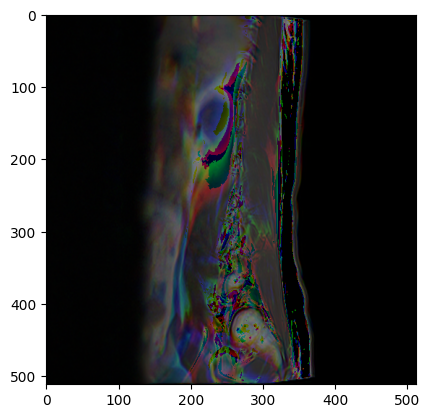

In [10]:
dicom_image_list = get_file_list(4003253, 'Sagittal T1')

input_image = get_dicom_input_data(4003253)
plt.imshow(input_image[:, :, 0:3])
input_data_gb = input_image.nbytes / 1024 / 1024 / 1024
print(f"画像サイズ[GB] : {input_data_gb}")
print(f'データセット全体のデータ数は {input_data_gb * STUDY_NUM}')

In [11]:
# データセットの保存
save_train_data()
save_valid_data()
save_test_data()

残りのデータ数 : 1580
残りのデータ数 : 1579
残りのデータ数 : 1578
残りのデータ数 : 1577
残りのデータ数 : 1576
残りのデータ数 : 1575
残りのデータ数 : 1574
残りのデータ数 : 1573
残りのデータ数 : 1572
残りのデータ数 : 1571
残りのデータ数 : 1570
残りのデータ数 : 1569
残りのデータ数 : 1568
残りのデータ数 : 1567
残りのデータ数 : 1566
残りのデータ数 : 1565
残りのデータ数 : 1564
残りのデータ数 : 1563
残りのデータ数 : 1562
残りのデータ数 : 1561
残りのデータ数 : 1560
残りのデータ数 : 1559
残りのデータ数 : 1558
残りのデータ数 : 1557
残りのデータ数 : 1556
残りのデータ数 : 1555
残りのデータ数 : 1554
残りのデータ数 : 1553
残りのデータ数 : 1552
残りのデータ数 : 1551
残りのデータ数 : 1550
残りのデータ数 : 1549
残りのデータ数 : 1548
残りのデータ数 : 1547
残りのデータ数 : 1546
残りのデータ数 : 1545
残りのデータ数 : 1544
残りのデータ数 : 1543
残りのデータ数 : 1542
残りのデータ数 : 1541
残りのデータ数 : 1540
残りのデータ数 : 1539
残りのデータ数 : 1538
残りのデータ数 : 1537
残りのデータ数 : 1536
残りのデータ数 : 1535
残りのデータ数 : 1534
残りのデータ数 : 1533
残りのデータ数 : 1532
残りのデータ数 : 1531
残りのデータ数 : 1530
残りのデータ数 : 1529
残りのデータ数 : 1528
残りのデータ数 : 1527
残りのデータ数 : 1526
残りのデータ数 : 1525
残りのデータ数 : 1524
残りのデータ数 : 1523
残りのデータ数 : 1522
残りのデータ数 : 1521
残りのデータ数 : 1520
残りのデータ数 : 1519
残りのデータ数 : 1518
残りのデータ数 : 1517
残りのデータ数 : 1516
残りのデータ数 : 1515
残りのデータ数 : 

In [ ]:
train_data_imgs, train_data_labels = load_data('train_data')

In [ ]:
train_data_imgs.shape